In [1]:
!pip install statsmodels --upgrade

     |████████████████████████████████| 9.5 MB 23.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
!pip install pycaret

     |████████████████████████████████| 264 kB 29.9 MB/s 
     |████████████████████████████████| 271 kB 68.3 MB/s 
     |████████████████████████████████| 6.8 MB 64.9 MB/s 
     |████████████████████████████████| 167 kB 61.0 MB/s 
     |████████████████████████████████| 1.3 MB 18.6 MB/s 
     |████████████████████████████████| 105 kB 63.5 MB/s 
     |████████████████████████████████| 14.4 MB 51 kB/s 
     |████████████████████████████████| 80 kB 10.0 MB/s 
     |████████████████████████████████| 1.7 MB 30.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 248 kB 57.1 MB/s 
     |████████████████████████████████| 2.0 MB 34.7 MB/s 
     |████████████████████████████████| 56 kB 4.1 MB/s 
     |████████████████████████████████| 3.1 MB 31.8 MB/s 
     |████████████████████████████████| 636 kB 42.9 MB/s 
     |█████████████████

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from warnings import filterwarnings
filterwarnings('ignore')

In [230]:
# IMPORT DADA FROM DRIVE

train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/fred_quarterly.csv')

## Data Preprocessing

In [231]:
train.head(5)

,date,month,quarter,Target,gnp,gdpdef,gdp
0,1/1/2000,2000-01,2000Q1,12935.252,10035.263,77.325,10002.179
1,4/1/2000,2000-04,2000Q2,13170.749,10283.391,77.807,10247.720
2,7/1/2000,2000-07,2000Q3,13183.890,10348.645,78.263,10318.165
3,10/1/2000,2000-10,2000Q4,13262.250,10490.430,78.688,10435.744
4,1/1/2001,2001-01,2001Q1,13219.251,10510.297,79.204,10470.231


In [232]:
train.describe()

,Target,gnp,gdpdef,gdp
count,86.000000,85.000000,86.000000,86.000000
mean,16043.371291,15788.494200,96.672000,15705.747209
std,1809.872040,3545.817776,11.154457,3528.301498
min,12935.252000,10035.263000,77.325000,10002.179000
25%,14868.853000,12996.998000,87.280000,12977.652500
50%,15781.342000,15339.711000,96.564000,15225.538000
75%,17456.204250,18565.145000,104.986500,18401.999250
max,19358.176000,22273.060000,117.380000,22722.581000


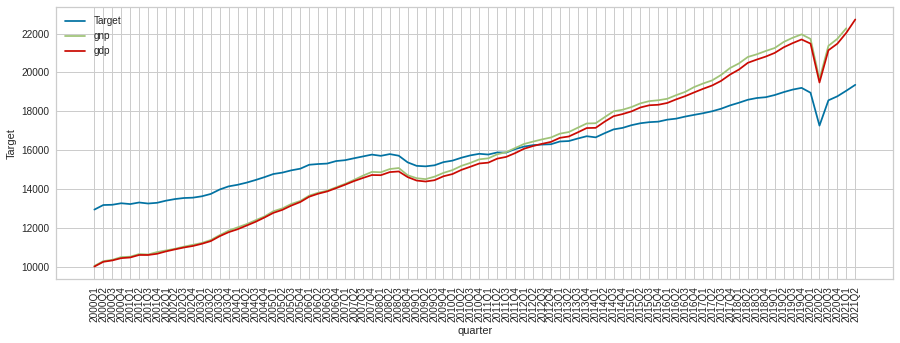

In [233]:
# Lets see how's the target variables
plt.figure(figsize=(15,5))
sns.lineplot(train['quarter'],train['Target'])
sns.lineplot(train['quarter'],train['gnp']) 	
sns.lineplot(train['quarter'],train['gdp'])
plt.legend(['Target','gnp','gdp'])
plt.xticks(rotation=90)
plt.show()

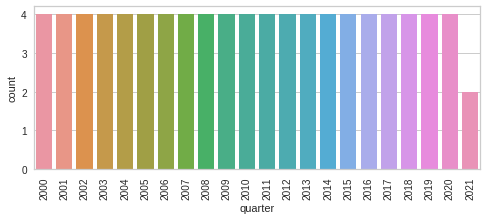

In [234]:
# checking for any quarter result missing 
plt.figure(figsize=(8,3))
sns.countplot(train['quarter'].apply(lambda x:x.split('Q')[0]))
plt.xticks(rotation=90)
plt.show()

There is no missing values in the quarter results. We have to predict for the upcoming six quarter . ie, two of  2021 and four of 2022 

In [235]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/fred_quarterly.csv')

In [236]:
# Lets create new features 
train['year'] = train['quarter'].apply(lambda x : x.split('Q')[0]).astype(int)
train['quarter_'] = train['quarter'].apply(lambda x : x.split('Q')[1]).astype(int)
train['Covid_flag'] = pd.Series(np.where(train['year'] >=2020, 1, 0))
#train['rolling_mean_4'] = train['Target'].shift(4).rolling(window=4).mean()
train['lag_1'] = train['Target'].shift(1)
train['lag_2'] = train['Target'].shift(2)
train['lag_4'] = train['Target'].shift(4)
train = train.set_index('quarter')

In [237]:
# Replace the NaN values for rolling_mean and lag_4 by corresponding values
#train['rolling_mean_4'].iloc[:7] = train['Target'].iloc[:7]
#train['lag_4'].iloc[:4] = train['Target'].iloc[:4]
# drop nan raws
train.drop(train.index[0:4],inplace=True)

In [238]:
# Select the feature needed for the time series
df  = train[['year','quarter_','Covid_flag','lag_1','lag_2','lag_4','Target']]

In [239]:
#Check for the  Missing values
df.isnull().sum()

year          0
quarter_      0
Covid_flag    0
lag_1         0
lag_2         0
lag_4         0
Target        0
dtype: int64

### Split the data for trainig and testing

In [240]:
# We can decide any boundary for training and testing 
def train_test_split(data,split_year,split_quarter):
  df_train = data[data['year']<split_year]
  df_test = data[data['year']>=split_year]
  return df_train,df_test

In [241]:
# We are split as 2019 boundary
df_train ,df_test = train_test_split(df,2020,1)

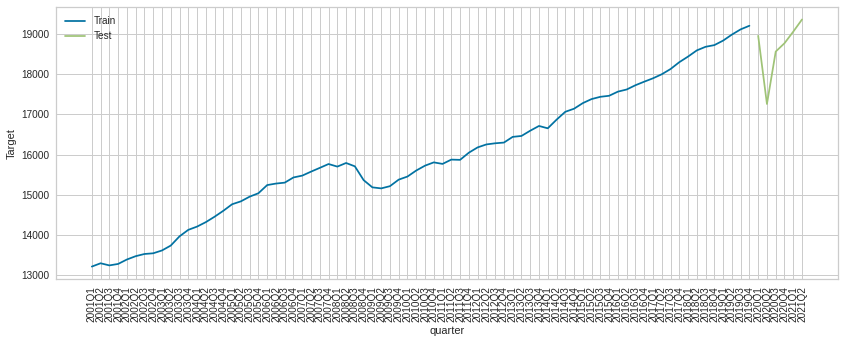

In [242]:
# Let's visulaize the target
plt.figure(figsize=(14,5))
sns.lineplot(df_train.index,df_train['Target'],label='Train')
sns.lineplot(df_test.index,df_test['Target'],label='Test')
plt.xticks(rotation=90)
plt.show()

## Create Model

In [243]:
# import regeression models pycaret
from pycaret.regression import *

In [244]:
# Setting up the model
reg = setup(data = df_train, target = 'Target',
              train_size = 0.9, 
              data_split_shuffle = False, fold_strategy = 'timeseries', fold = 3,
              silent = True, verbose = False, session_id = 123)

In [245]:
best = compare_models(sort='MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,6.616230e+01,9.809092e+03,9.252730e+01,8.994000e-01,0.0058,0.0042,0.0267
omp,Orthogonal Matching Pursuit,1.021003e+02,2.331653e+04,1.253732e+02,7.304000e-01,0.0079,0.0065,0.0167
lasso,Lasso Regression,1.427425e+02,4.565678e+04,1.726669e+02,4.670000e-01,0.0109,0.0091,0.0200
par,Passive Aggressive Regressor,1.544076e+02,3.850117e+04,1.944504e+02,6.651000e-01,0.0121,0.0096,0.0167
ridge,Ridge Regression,1.603901e+02,5.239182e+04,1.897122e+02,3.966000e-01,0.0119,0.0102,0.0167
en,Elastic Net,1.609204e+02,5.535955e+04,1.906158e+02,3.548000e-01,0.0120,0.0102,0.0167
br,Bayesian Ridge,1.668328e+02,5.966533e+04,1.965544e+02,3.022000e-01,0.0124,0.0106,0.0200
llar,Lasso Least Angle Regression,1.806673e+02,5.150787e+04,2.068193e+02,4.574000e-01,0.0129,0.0113,0.0200
lr,Linear Regression,5.799157e+02,5.141648e+05,6.241235e+02,-2.203400e+00,0.0377,0.0347,0.9067
gbr,Gradient Boosting Regressor,7.130756e+02,7.061652e+05,8.230158e+02,-3.921700e+00,0.0509,0.0429,0.0433


#### Create Baseline model

In [246]:
#we create a model
model = create_model('huber')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,91.3476,20204.1206,142.1412,0.7502,0.0091,0.0059
1,61.7064,5296.0502,72.7740,0.9660,0.0046,0.0039
2,45.4330,3927.1065,62.6666,0.9820,0.0037,0.0026
Mean,66.1623,9809.0924,92.5273,0.8994,0.0058,0.0042
SD,19.0075,7371.6104,35.3242,0.1057,0.0024,0.0014


In [247]:
tuned_model = tune_model(model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,85.0303,18111.5283,134.5791,0.7760,0.0087,0.0055
1,61.7028,5294.2711,72.7617,0.9660,0.0046,0.0039
2,45.4268,3927.3532,62.6686,0.9820,0.0037,0.0026
Mean,64.0533,9111.0509,90.0031,0.9080,0.0056,0.0040
SD,16.2533,6388.7173,31.7881,0.0936,0.0022,0.0012


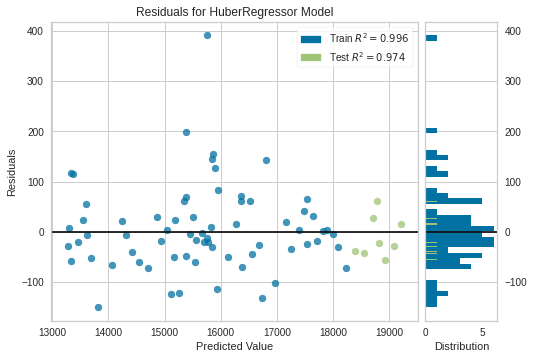

In [248]:
plot_model(tuned_model)

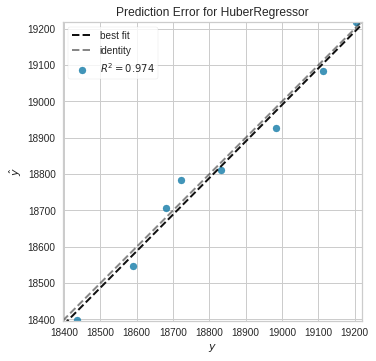

In [249]:
plot_model(tuned_model, plot = 'error')

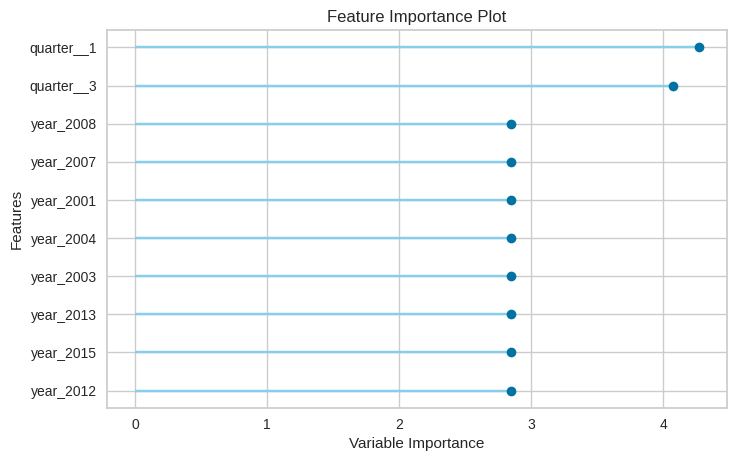

In [250]:
from statsmodels.graphics.tsaplots import plot_acf
plot_model(tuned_model, plot='feature') 

In [251]:
# generate predictions on the original dataset
predictions = predict_model(tuned_model, data=df)# add a date column in the dataset

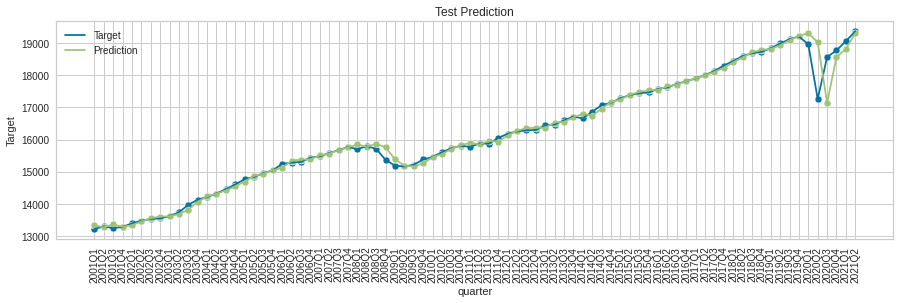

In [252]:
plt.figure(figsize=(15,4))
sns.scatterplot(predictions.index,predictions['Target'])
sns.lineplot(predictions.index,predictions['Target'],label='Target')
sns.scatterplot(predictions.index,predictions['Label'])
sns.lineplot(predictions.index,predictions['Label'],label='Prediction')
plt.title('Test Prediction')
plt.xticks(rotation=90)
plt.show()

### Blending or Stacking of Model
We will now create a blend model using four algorithms :huber,omp,lasso,par







In [253]:
huber = create_model('huber', verbose = False)
omp = create_model('omp', verbose = False)
lasso = create_model('lasso',verbose=False)
par = create_model('par',verbose=False)

In [254]:
# Tune models
tuned_huber = tune_model(huber,verbose=False)
tuned_omp = tune_model(omp,verbose=False)
tuned_lasso = tune_model(lasso,verbose=False)
tuned_par = tune_model(par,verbose=False)

In [255]:
blend_specific = blend_models(estimator_list = [tuned_huber,tuned_omp,tuned_lasso,tuned_par],verbose=False)

In [256]:
# predictions 
predictions_blend = predict_model(blend_specific, data=df)

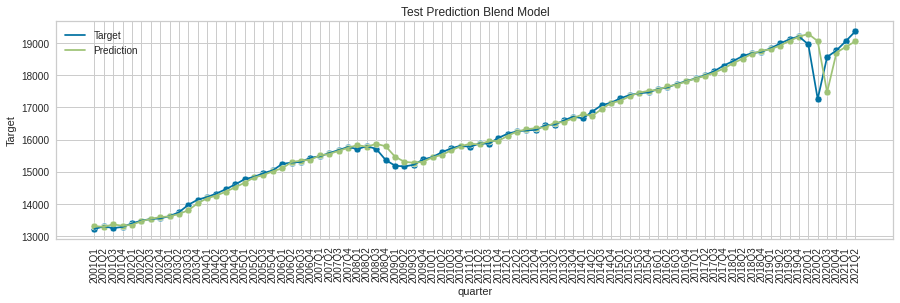

In [257]:
plt.figure(figsize=(15,4))
sns.scatterplot(predictions_blend.index,predictions_blend['Target'])
sns.lineplot(predictions_blend.index,predictions_blend['Target'],label='Target')
sns.scatterplot(predictions_blend.index,predictions_blend['Label'])
sns.lineplot(predictions_blend.index,predictions_blend['Label'],label='Prediction')
plt.title('Test Prediction Blend Model')
plt.xticks(rotation=90)
plt.show()

## Predict future values
Let's predict future 6 quarters Target valuels 

In [258]:
# drop covid flag,since it doest have much influence on predictoins
df.drop('Covid_flag',axis=1,inplace=True)

In [259]:
# Lets run the model using whole dataset since we dont need any trainig data
# Setting up the model
reg = setup(data = df, target = 'Target',
              train_size = 0.9, 
              data_split_shuffle = False, fold_strategy = 'timeseries', fold = 3,
              silent = True, verbose = False, session_id = 123)

In [260]:
best = compare_models(sort='MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,6.823940e+01,9.647678e+03,9.147060e+01,8.519000e-01,0.0056,0.0042,0.0300
omp,Orthogonal Matching Pursuit,8.467740e+01,1.616820e+04,1.060470e+02,7.091000e-01,0.0066,0.0053,0.0200
lasso,Lasso Regression,1.136931e+02,2.964786e+04,1.355886e+02,4.395000e-01,0.0085,0.0072,0.0200
ridge,Ridge Regression,1.172870e+02,2.989244e+04,1.451288e+02,4.606000e-01,0.0090,0.0073,0.0200
en,Elastic Net,1.202969e+02,3.195999e+04,1.441496e+02,4.082000e-01,0.0090,0.0076,0.0267
br,Bayesian Ridge,1.229135e+02,3.339098e+04,1.469816e+02,3.814000e-01,0.0092,0.0078,0.0167
llar,Lasso Least Angle Regression,1.433713e+02,3.452951e+04,1.735066e+02,4.891000e-01,0.0107,0.0089,0.0200
par,Passive Aggressive Regressor,3.184267e+02,1.533556e+05,3.507357e+02,-5.971000e-01,0.0219,0.0197,0.0233
lr,Linear Regression,7.068149e+02,7.221827e+05,7.633707e+02,-2.856100e+00,0.0455,0.0412,0.0200
gbr,Gradient Boosting Regressor,7.500376e+02,7.804452e+05,8.637460e+02,-4.541800e+00,0.0525,0.0444,0.0500


In [261]:
#we create a model
model_final = create_model('huber')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,89.8946,19491.0902,139.6105,0.6047,0.0090,0.0058
1,68.8743,6550.1437,80.9330,0.9616,0.0049,0.0042
2,45.9492,2901.8011,53.8684,0.9895,0.0030,0.0026
Mean,68.2394,9647.6783,91.4706,0.8519,0.0056,0.0042
SD,17.9463,7117.9196,35.7884,0.1752,0.0025,0.0013


In [262]:
tuned_model_final = tune_model(model_final)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,87.1612,18549.8107,136.1977,0.6238,0.0088,0.0057
1,68.9419,6559.5173,80.9908,0.9616,0.0049,0.0042
2,31.9316,1440.1801,37.9497,0.9948,0.0021,0.0018
Mean,62.6782,8849.8360,85.0461,0.8600,0.0053,0.0039
SD,22.9783,7170.2643,40.2119,0.1676,0.0027,0.0016


In [263]:
# generate predictions on the original dataset
predictions_final = predict_model(tuned_model_final, data=df)# add a date column in the dataset

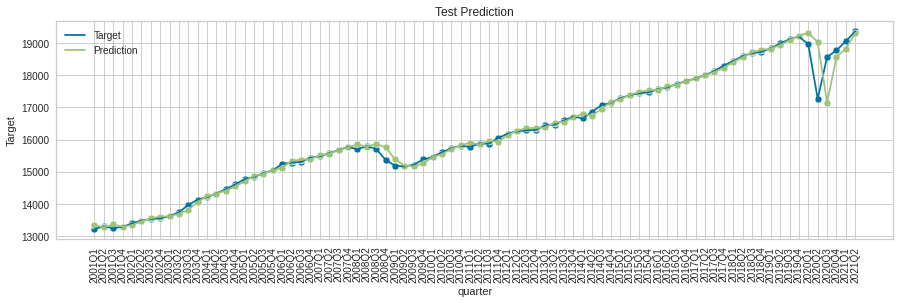

In [264]:
plt.figure(figsize=(15,4))
sns.scatterplot(predictions_final.index,predictions_final['Target'])
sns.lineplot(predictions_final.index,predictions_final['Target'],label='Target')
sns.scatterplot(predictions_final.index,predictions_final['Label'])
sns.lineplot(predictions_final.index,predictions_final['Label'],label='Prediction')
plt.title('Test Prediction')
plt.xticks(rotation=90)
plt.show()

In [265]:
# Let's create the features for the next 6 quarters
# prediction for old quarters
# generate predictions on the original dataset

In [266]:
# Generate data for future quarters
def data_gen(year,quarter):
  data_ = pd.DataFrame([[year,quarter,predictions_final['Target'].iloc[-1],
                        predictions_final['Target'].iloc[-2],predictions_final['Target'].iloc[-4],0]],
                        columns=df.columns,index=[str(year)+'Q'+str(quarter)])
  return data_

In [267]:
# Lets predict for the quarter '2021Q3'
data_ = data_gen(2021,3)
data_ = predict_model(tuned_model_final,data_)
data_['Target'] = data_['Label']
predictions_final = pd.concat([predictions_final,data_])

# Lets predict for the quarter '2021Q4'
data_ = data_gen(2021,4)
data_ = predict_model(tuned_model_final,data_)
data_['Target'] = data_['Label']
predictions_final = pd.concat([predictions_final,data_])

In [268]:
# Lets predict for the quarter '2022Q1'
data_ = data_gen(2022,1)
data_ = predict_model(tuned_model_final,data_)
data_['Target'] = data_['Label']
predictions_final = pd.concat([predictions_final,data_])

# Lets predict for the quarter '2022Q2'
data_ = data_gen(2022,2)
data_ = predict_model(tuned_model_final,data_)
data_['Target'] = data_['Label']
predictions_final = pd.concat([predictions_final,data_])

# Lets predict for the quarter '2022Q3'
data_ = data_gen(2022,3)
data_ = predict_model(tuned_model_final,data_)
data_['Target'] = data_['Label']
predictions_final = pd.concat([predictions_final,data_])

# Lets predict for the quarter '2022Q4'
data_ = data_gen(2022,4)
data_ = predict_model(tuned_model_final,data_)
data_['Target'] = data_['Label']
predictions_final = pd.concat([predictions_final,data_])

In [269]:
predictions_final.tail(10)

,year,quarter_,lag_1,lag_2,lag_4,Target,Label
2020Q3,2020,3,17258.205000,18951.992000,19112.653000,18560.774000,17144.225254
2020Q4,2020,4,18560.774000,17258.205000,19202.310000,18767.778000,18566.354789
2021Q1,2021,1,18767.778000,18560.774000,18951.992000,19055.655000,18820.206813
2021Q2,2021,2,19055.655000,18767.778000,17258.205000,19358.176000,19307.139877
2021Q3,2021,3,19358.176000,19055.655000,18560.774000,19511.816836,19511.816836
2021Q4,2021,4,19511.816836,19358.176000,18767.778000,19656.681284,19656.681284
2022Q1,2022,1,19656.681284,19511.816836,19055.655000,19789.355750,19789.355750
2022Q2,2022,2,19789.355750,19656.681284,19358.176000,19909.751194,19909.751194
2022Q3,2022,3,19909.751194,19789.355750,19511.816836,20026.326155,20026.326155
2022Q4,2022,4,20026.326155,19909.751194,19656.681284,20136.441519,20136.441519


In [270]:
# separate the data back to df and predict values
df_prediction = predictions_final.loc[:'2021Q2',:]
future_prediction = predictions_final.loc['2021Q3':,:]

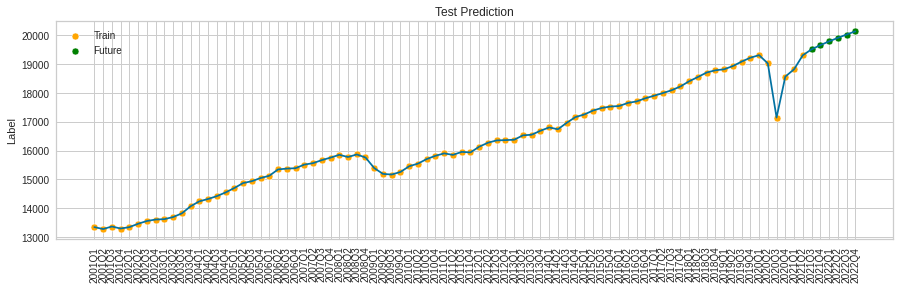

In [271]:
plt.figure(figsize=(15,4))
sns.lineplot(predictions_final.index,predictions_final['Label'])
sns.scatterplot(df_prediction.index,df_prediction['Label'],color='orange',label='Train')
sns.scatterplot(future_prediction.index,future_prediction['Label'],color='Green',label='Future')

plt.title('Test Prediction')
plt.xticks(rotation=90)
plt.show()